# Patches windows and their use in interpolation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from invwidget import inversion_widget
from scipy.signal import convolve
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from pylops.basicoperators import *
from pylops.utils import dottest
from pylops.optimization.solver import cgls
from pylops.optimization.sparsity import FISTA

from pylops import LinearOperator, MatrixMult, MemoizeOperator
from pylops.signalprocessing import FFT2D, Sliding1D, Sliding2D, Patch2D

## 1d sliding

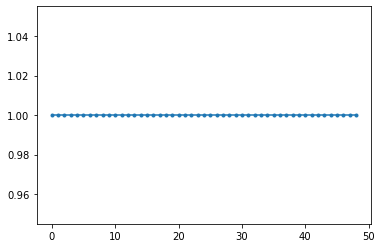

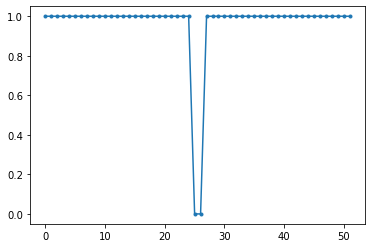

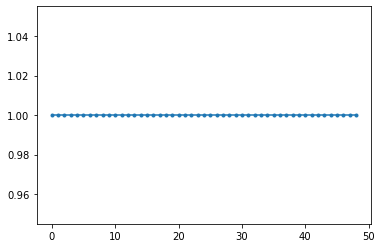

In [2]:
dimd = 49
nwin = 26
nover = 3
dim = 2*nwin

Op = Identity(nwin, nwin)
Sop1 = Sliding1D(Op.H, dim, dimd, nwin, nover,
                 tapertype='cosine', design=True)

x = np.ones(dim)
y = Sop1 * x
xinv = Sop1.div(y)

yinv = Sop1 * xinv

plt.figure()
plt.plot(y, '.-')

plt.figure()
plt.plot(xinv, '.-')

plt.figure()
plt.plot(yinv, '.-')

## 2d sliding

In [3]:
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)
data = data[:, 60:]
pad = 12
data = np.pad(data, ((pad, pad), (pad, pad)), mode='edge')

In [4]:
dimsd = data.shape
nwin = 26
nover = 4
dims = (7*256, 256)

Op = FFT2D((nwin, dimsd[1]), nffts=(256, 256))
Sop = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                tapertype=None, design=True)
Sop1 = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                 tapertype='cosine', design=True)

y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
y1 = Sop1 * x.ravel()
y1 = y1.reshape(dimsd)

xinv = Sop1.div(y.ravel(), 50)

yinv = Sop1 * xinv.ravel()
yinv = yinv.reshape(dimsd)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, tol=1e-2)

True

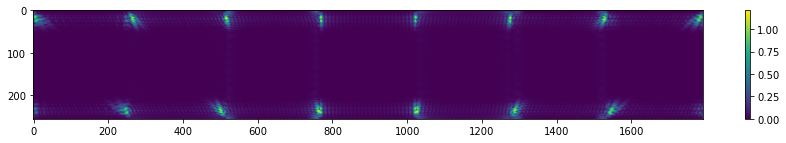

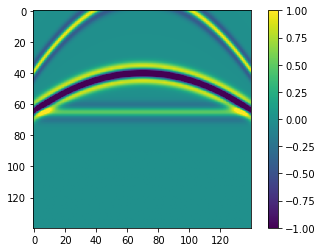

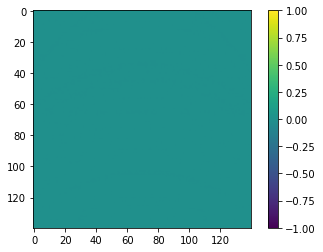

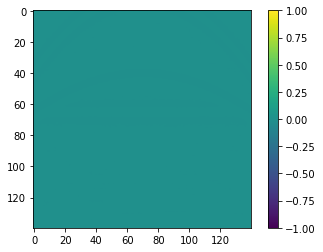

In [5]:
plt.figure(figsize=(15, 2))
plt.imshow(np.abs(x).T)
plt.colorbar()
plt.axis('tight')
          
plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-y1[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-yinv[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar();

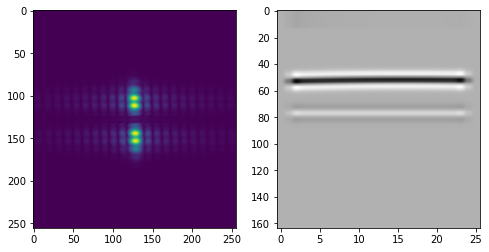

In [6]:
slides_inend = np.arange(0, 7*256*256+1, 256*256)

islide = 3

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(xinv.ravel()[slides_inend[islide]:slides_inend[islide+1]].reshape(256, 256).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Op.H * xinv.ravel()[slides_inend[islide]:slides_inend[islide+1]].T).reshape(nwin, dimsd[1]).T), 
              cmap='gray')
axs[1].axis('tight');

## 2d patches

(-0.5, 163.5, 163.5, -0.5)

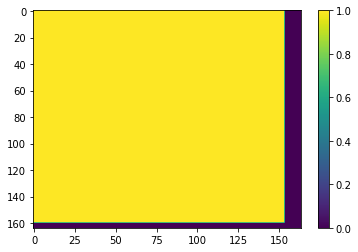

In [7]:
dimsd = data.shape
nwin = (20, 34)
nover = (10, 4)
nop = (64, 64)
nwins = (15, 5)
dims = (nwins[0]*nop[0], nwins[1]*nop[1])

Op = Identity(nwin[0]*nwin[1], nwin[0]*nwin[1])
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine', design=True)

y = Sop * np.ones(Sop.shape[1])

plt.figure()
plt.imshow(y.reshape(dimsd[0], dimsd[1]))
plt.colorbar()
plt.axis('tight')

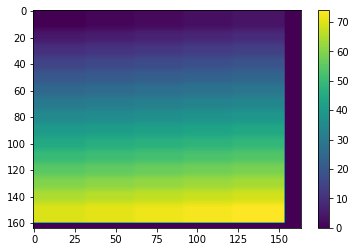

In [8]:
#with scalings
scalings = np.arange(nwins[0]*nwins[1])

Op = Identity(nwin[0]*nwin[1], nwin[0]*nwin[1])
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine', design=True, scalings=scalings)

y = Sop * np.ones(Sop.shape[1])

plt.figure()
plt.imshow(y.reshape(dimsd[0], dimsd[1]))
plt.colorbar()
plt.axis('tight');

In [9]:
dimsd = data.shape
nwin = (20, 34)
nover = (10, 4)
nop = (64, 64)
dims = (15*64, 5*64)

Op = FFT2D(nwin, nffts=nop)
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype=None, design=True)
Sop1 = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine', design=True)

y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
y1 = Sop1 * x.ravel()
y1 = np.real(y1).reshape(dimsd)

xinv = Sop1.div(y.ravel(), 5)

yinv = Sop1 * xinv.ravel()
yinv = np.real(yinv).reshape(dimsd)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, tol=1e-2)

True

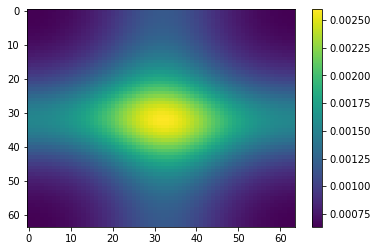

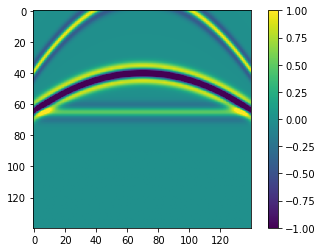

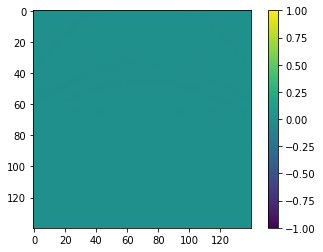

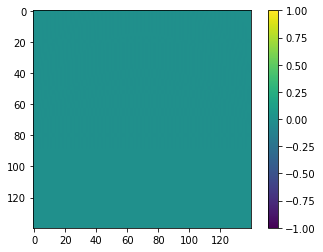

In [10]:
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(x.ravel()[:nop[0]*nop[1]].reshape(nop).T)))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-y1[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-yinv[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar();

## Interpolation

In [11]:
inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# irregular subsampling
np.random.seed(5)
perc_subsampling=0.6
Nsub=int(np.round(par['nx']*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# regular subsampling
#iava = np.arange(par['nx'])[::5]
#Nsub = len(iava)

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

# Create fft operator
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], 
              sampling=[par['dx'], par['dt']])

# Data
y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=400.070111 - u^T(Op^Tv)=400.070111


In [12]:
dimsd = x.shape
nwin = (20, 34)
nover = (10, 4)
nop = (64, 64)
nwins = (9, 23)
dims = (nwins[0]*nop[0], nwins[1]*nop[1])

Fop = FFT2D(nwin, nffts=nop)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop,
              tapertype='hanning', # 'cosine'
              design=True)
#p = Sop.H * x.ravel()
p = Sop.div(x.ravel(), 50)
pmask = Sop.div(ymask.ravel(), 50)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, tol=1e-2)

  896  960 1024 1088 1152 1216 1280 1344 1408], end:[  64  128  192  256  320  384  448  512  576  640  704  768  832  896
  960 1024 1088 1152 1216 1280 1344 1408 1472]
 540 570 600 630 660], end:[ 34  64  94 124 154 184 214 244 274 304 334 364 394 424 454 484 514 544
 574 604 634 664 694]


True

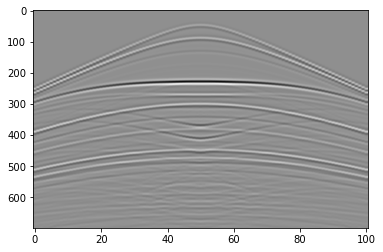

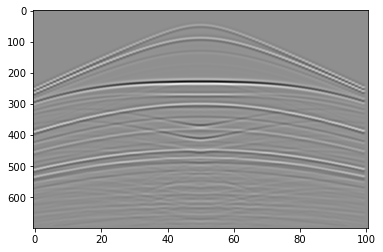

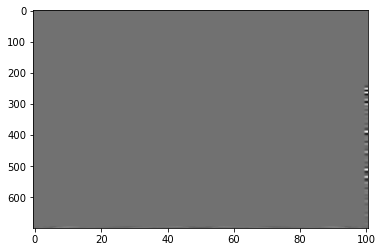

In [13]:
plt.figure()
plt.imshow(x.T, cmap='gray')
plt.axis('tight')

plt.figure()
plt.imshow(np.real(Sop * p).reshape(par['nx'], par['nt']).T, cmap='gray')
plt.axis('tight');

plt.figure()
plt.imshow(x.T - np.real(Sop * p).reshape(par['nx'], par['nt']).T, cmap='gray')
plt.axis('tight');

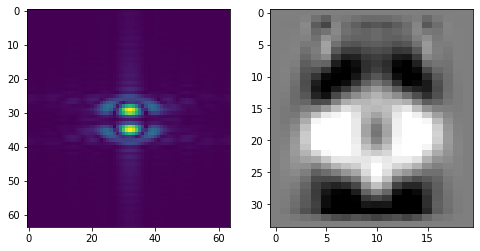

In [14]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 18

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

In [15]:
def callback(x, xhistory, Pop, xshape, xtrue=None, xerror=None):
    x = np.real(Pop * x).reshape(xshape).T
    xhistory.append(x)
    if xtrue is not None:
        xerror.append(np.linalg.norm(x-xtrue))

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 42700 rows and 847872 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 2.500000e-01	thresh = 6.250000e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -0.00000e+00   7.798e-01   8.887e-01   2.007e-01
     2  -0.00000e+00   6.381e-01   8.322e-01   1.647e-01
     3  -0.00000e+00   5.095e-01   7.894e-01   1.751e-01
     4  -0.00000e+00   4.044e-01   7.629e-01   1.722e-01
     5  -0.00000e+00   3.244e-01   7.498e-01   1.608e-01
     6  -0.00000e+00   2.664e-01   7.448e-01   1.454e-01
     7  -0.00000e+00   2.256e-01   7.433e-01   1.294e-01
     8  -0.00000e+00   1.973e-01   7.418e-01   1.154e-01
     9  -0.00000e+00   1.778e-01   7.389e-01   1.041e-01
    10  -0.00000e+00   1.642e-01   7.344e-01   9.550e-02
    11  -0.00000e+00   1.547e-01   7.287e-01   8.880e-02
    21  -0.00000e

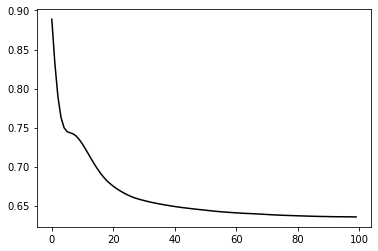

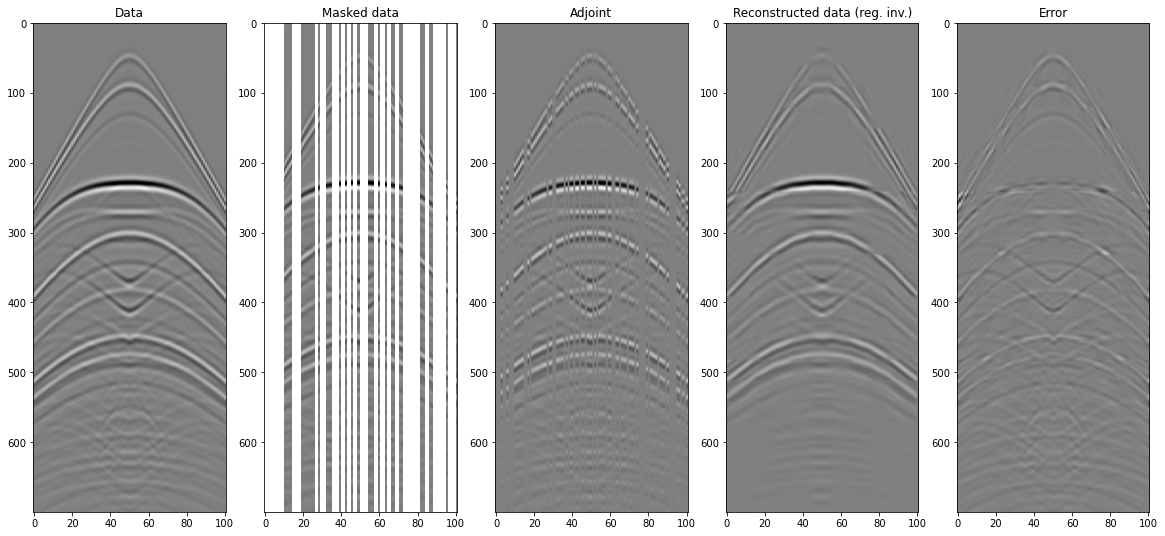

In [16]:
Op = Rop * Sop

niters = 100
xhist = []
xerror = []
prec, _, cost = FISTA(Op, y.ravel(), niter=niters, eps=5e-3, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
                      tol=1e-10, returninfo=True, show=True, 
                      callback=lambda xinv: callback(xinv, xhist, Sop, (par['nx'], par['nt']), x.T, xerror))
xrec = np.real(Sop * prec)
xrec = xrec.reshape(par['nx'], par['nt'])
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

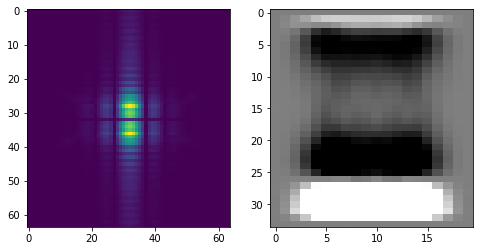

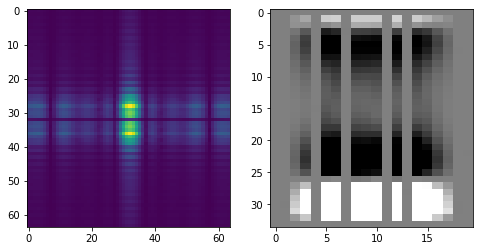

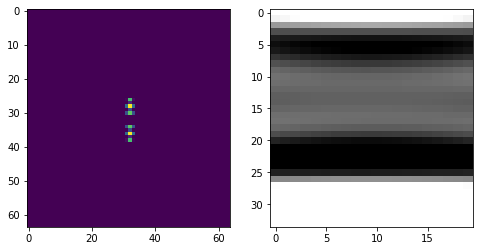

In [17]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 8

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(prec[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * prec[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

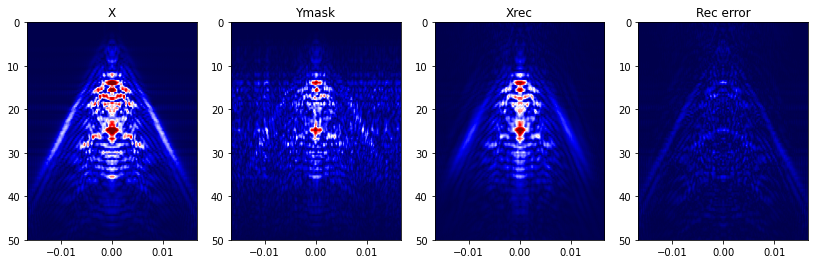

In [18]:
X = (FFTop * x.ravel()).reshape(nfft, nfft)
Y = (FFTop * ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);

In [19]:
inversion_widget(ymask.T, xhist, cost, error=np.array(xerror), model_true=x.T, title='Reconstruction Widget')

Output()

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 42700 rows and 847872 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 2.500000e-01	thresh = 6.250000e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -0.00000e+00   7.798e-01   8.887e-01   2.007e-01
     2  -0.00000e+00   6.347e-01   8.329e-01   1.674e-01
     3  -0.00000e+00   5.006e-01   7.927e-01   1.801e-01
     4  -0.00000e+00   3.891e-01   7.714e-01   1.792e-01
     5  -0.00000e+00   3.030e-01   7.661e-01   1.691e-01
     6  -0.00000e+00   2.396e-01   7.713e-01   1.540e-01
     7  -0.00000e+00   1.943e-01   7.813e-01   1.373e-01
     8  -0.00000e+00   1.622e-01   7.920e-01   1.217e-01
     9  -0.00000e+00   1.393e-01   8.009e-01   1.084e-01
    10  -0.00000e+00   1.227e-01   8.072e-01   9.790e-02
    11  -0.00000e+00   1.105e-01   8.111e-01   8.968e-02
    21  -0.00000e

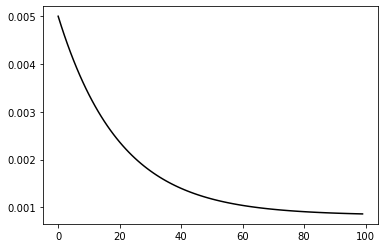

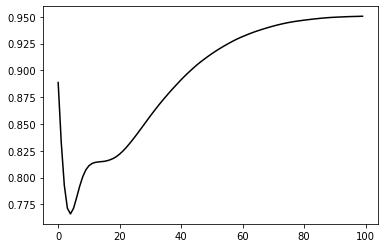

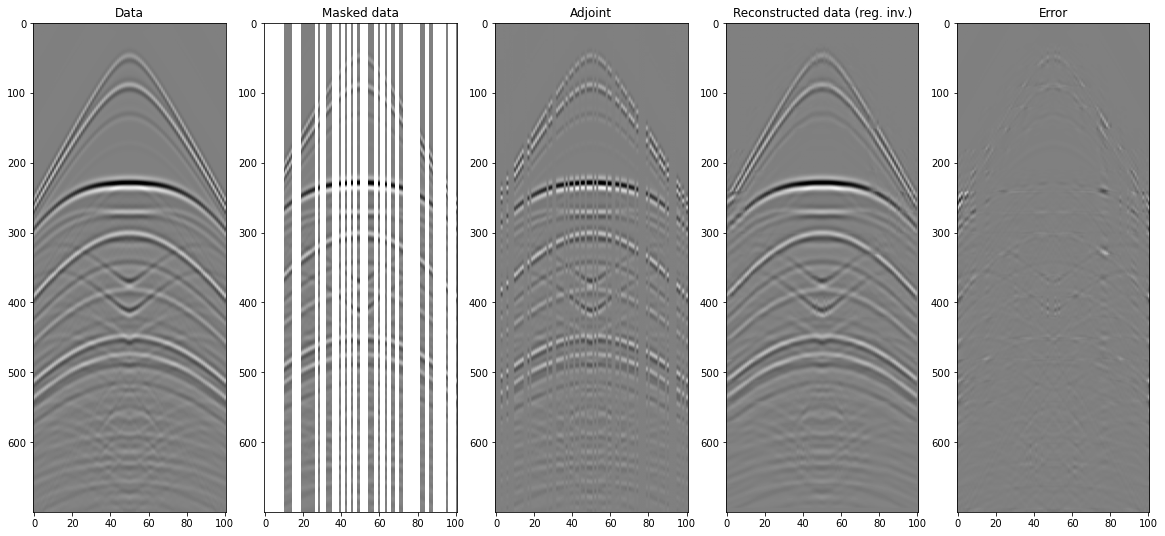

In [25]:
# Synthesis problem
eps = 5e-3
niter = 100
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(eps*decay, 'k')

xhist = []
xerror = []
prec, _, cost = FISTA(Op, y.ravel(), niter=niter, eps=eps, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
                      decay=decay, tol=1e-10, returninfo=True, show=True,
                      callback=lambda xinv: callback(xinv, xhist, Sop, (par['nx'], par['nt']), x.T, xerror))


xrec = np.real(Sop * prec)
xrec = xrec.reshape(par['nx'], par['nt'])
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

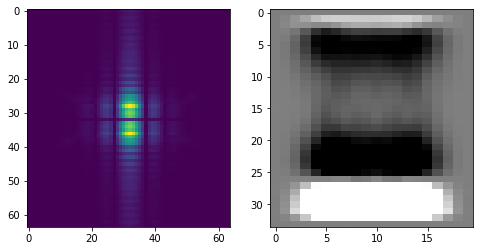

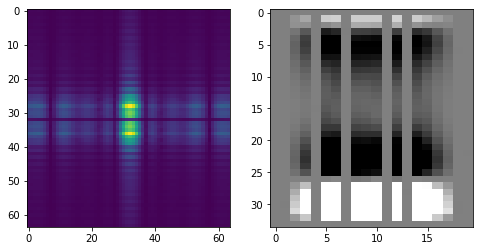

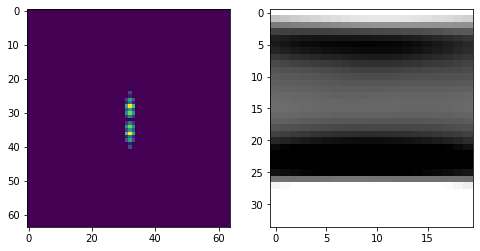

In [26]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 8

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(prec[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * prec[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

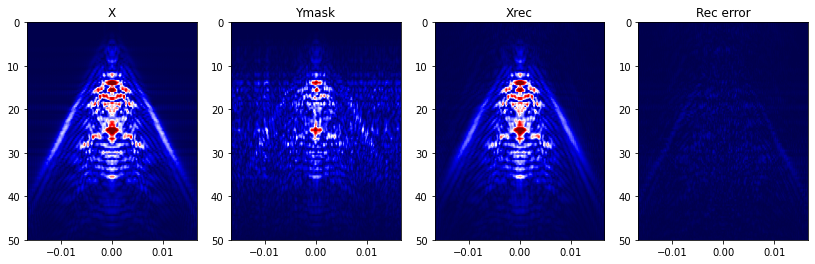

In [27]:
X = (FFTop* x.ravel()).reshape(nfft, nfft)
Y = (FFTop* ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);

In [28]:
inversion_widget(ymask.T, xhist, cost, error=np.array(xerror), model_true=x.T, title='Reconstruction Widget')

Output()

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 42700 rows and 70700 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 1.000000e+00	thresh = 2.500000e-03
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   3.523e-01   7.071e-01   7.034e-01
     2   0.00000e+00   3.298e-01   7.397e-01   1.060e-01
     3   0.00000e+00   3.121e-01   7.657e-01   8.819e-02
     4   0.00000e+00   2.991e-01   7.847e-01   6.899e-02
     5   0.00000e+00   2.893e-01   7.979e-01   5.294e-02
     6   0.00000e+00   2.813e-01   8.071e-01   4.036e-02
     7   0.00000e+00   2.743e-01   8.134e-01   3.046e-02
     8   0.00000e+00   2.677e-01   8.179e-01   2.298e-02
     9   0.00000e+00   2.616e-01   8.211e-01   1.806e-02
    10   0.00000e+00   2.557e-01   8.234e-01   1.549e-02
    11   0.00000e+00   2.501e-01   8.252e-01   1.439e-02
    21   0.00000e+

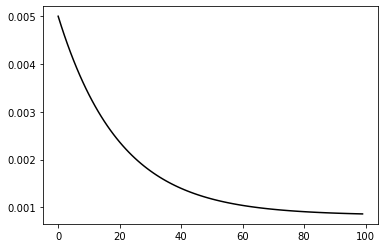

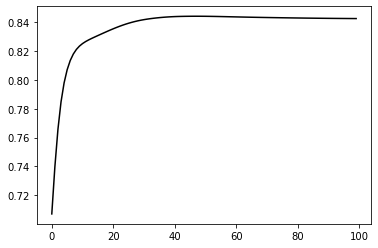

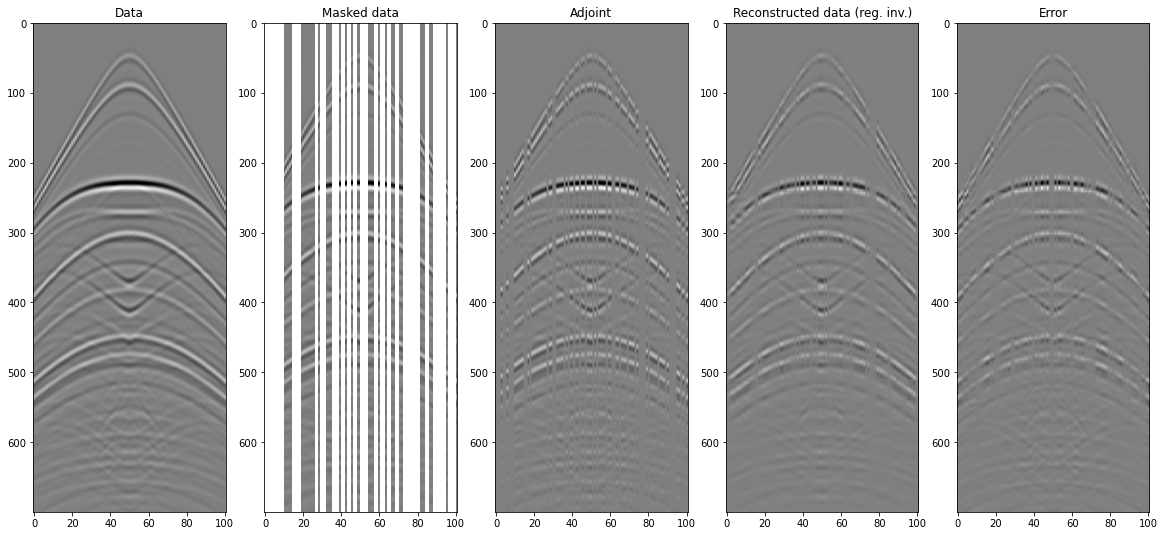

In [23]:
# Analysis problem
eps = 5e-3
niter = 100
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(eps*decay, 'k')

Rop.dtype = np.complex128
xrec, _, cost = FISTA(Rop, y.ravel(), niter=niter, eps=eps, alpha=1., #eigsiter=10, eigstol=1e-1, 
                      SOp=Sop, decay=decay, tol=1e-10, returninfo=True, show=True)
xrec = np.real(xrec.reshape(par['nx'], par['nt']))
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

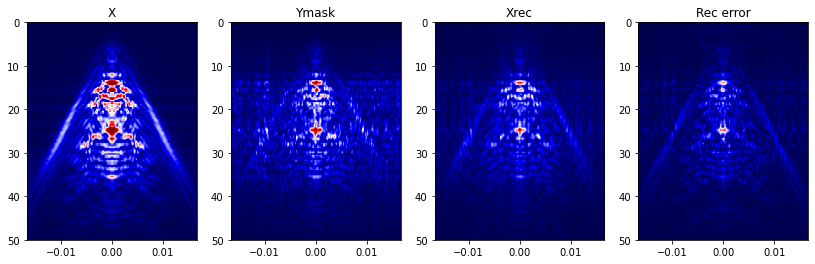

In [24]:
X = (FFTop* x.ravel()).reshape(nfft, nfft)
Y = (FFTop* ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);